In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [100]:
# resizing of the data created with monte carlo
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant

lt, ut, t_step = 0.7, 3.2, 0.003

for L in [10, 15]:
    utils.resize_data(L, lt, ut, t_step)

In [ ]:
def analysis(L, dim_hidden=30, lr=1e-4, tol=1e-5 ):

    lt, ut, t_step = 0.7, 3.2, 0.003
    n = int((ut-lt) / t_step) # number of datapoints

    data = np.load(f"data/{L}.npy")
    temps = np.load(f"data/{L}_temp.npy")

    # target value
    t = (temps > T_CRIT).astype(int)

    # DATA Shuffling
    rng = np.random.default_rng()
    indices = np.arange(data.shape[0])
    rng.shuffle(indices)

    data = data[indices]
    t = t[indices]
    temps = temps[indices]

    # splitting data in 60% training, 30% validation, 10% test
    a, b = int(0.7*n), int(0.9*n)
    data_train = data[:a]
    data_val = data[a:b]
    data_test = data[b:]

    t_train = t[:a]
    t_val = t[a:b]
    t_test = t[b:]

    # CLASSIFIER TRAINING
    #clf = MLPBinary(dim_hidden=dim_hidden, tolerance=tol)
    #clf.fit(data_train, t_train, X_val=data_val, t_val=t_val ,lr=lr)

    # using skleanr
    clf = MLPClassifier()
    clf.fit(data_train, t_train)

    # plotting accuracy and loss
    fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))
    E = len(clf.train_acc) 
    ax1.plot(np.arange(E), clf.train_acc)
    ax1.plot(np.arange(E), clf.val_acc)
    ax1.legend(["train_acc", "val_acc"])

    E = len(clf.loss) 
    ax1.plot(np.arange(E), clf.loss)
    ax1.plot(np.arange(E), clf.val_acc)
    ax1.legend(["train_acc", "val_acc"])

    ax2.plot(np.arange(E), clf.train_loss)
    ax2.plot(np.arange(E), clf.val_loss)
    ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
    ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
    ax2.legend(["train_loss", "val_loss"])

    return clf, data_test, t_test, temps


In [112]:
data = np.load(f"data/{L}.npy")
temps = np.load(f"data/{L}_temp.npy")
t = (temps > T_CRIT).astype(int)

In [115]:
310/833


0.37214885954381755

TypeError: object of type 'NoneType' has no len()

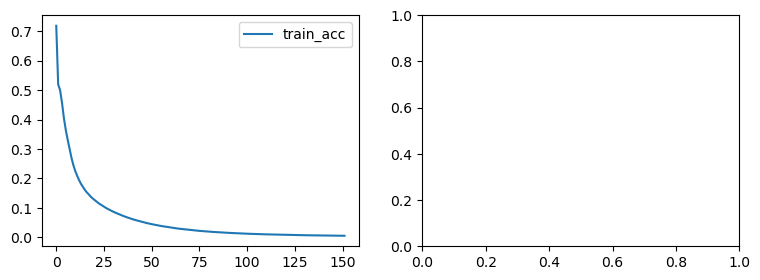

In [102]:
L=15
lt, ut, t_step = 0.7, 3.2, 0.003
n = int((ut-lt) / t_step) # number of datapoints
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant

data = np.load(f"data/{L}.npy")
temps = np.load(f"data/{L}_temp.npy")

# target value
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 60% training, 30% validation, 10% test
a, b = int(0.7*n), int(0.9*n)
data_train = data[:a]
data_val = data[a:b]
data_test = data[b:]

t_train = t[:a]
t_val = t[a:b]
t_test = t[b:]

# CLASSIFIER TRAINING
#clf = MLPBinary(dim_hidden=dim_hidden, tolerance=tol)
#clf.fit(data_train, t_train, X_val=data_val, t_val=t_val ,lr=lr)

# using skleanr
clf = MLPClassifier()
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(len(clf.validation_scores_)), clf.validation_scores_)

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [103]:
clf.score(data_test, t_test)

0.9285714285714286

In [64]:
clf.validation_scores_.shape

AttributeError: 'NoneType' object has no attribute 'shape'

1

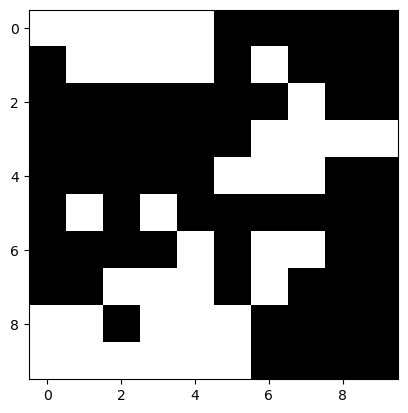

In [4]:
i = 1700
plt.imshow(data[i].reshape(10,10), cmap='grey') # 1 white, -1 black
t[i]

c:\Users\CrisMattGiov\miniconda3\envs\in3050\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AttributeError: 'MLPClassifier' object has no attribute 'train_acc'

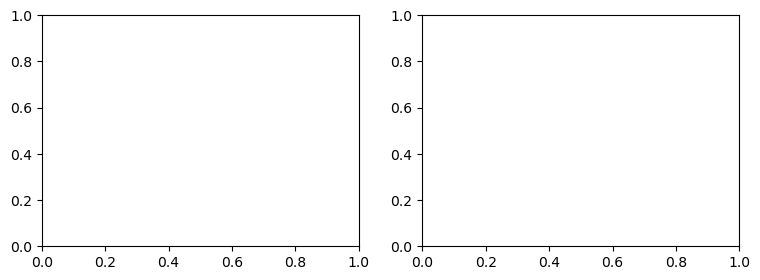

In [54]:
clf, data_test, t_test, temps = analysis(10, dim_hidden=20, lr=1e-5, tol=1e-5)



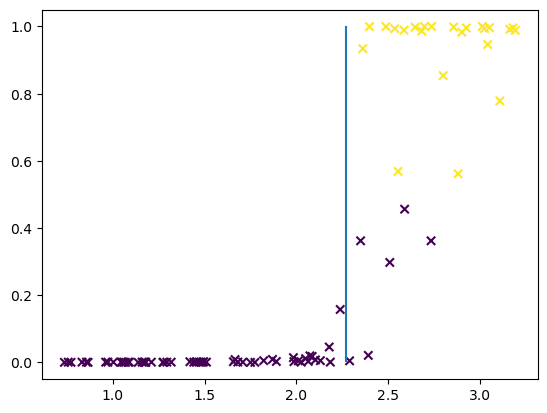

In [110]:
out = clf.predict_proba(data_test)
plt.scatter(temps[b:], out[:,1], marker='x', c=clf.predict(data_test) )
plt.vlines(T_CRIT, 0, 1)